# Sign Language MNIST

## Prepare Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

train = pd.read_csv('./sign_mnist_train.csv')
test  = pd.read_csv('./sign_mnist_test.csv')

train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


In [2]:
from tensorflow.keras.utils import to_categorical

def convert_dataset(ds, pixles_x, pixels_y, length, features):
    for index in range(length):
        img = np.array([ds.iloc[index][1:].values.reshape(pixles_x,pixels_y)])
        label = np.array([ds.iloc[index][0]])
        if index == 0:
            x = np.array(img)
            y = np.array(label)
        else:
            x = np.append(x, img, axis=0)
            y = np.append(y, label, axis=0)
    x = x.astype('float32') / 255
    x = np.expand_dims(x,-1)
    y = to_categorical(y, features)
    return (x,y)

x_train, y_train = convert_dataset(train, 28, 28, len(train), 25)
print(x_train.shape)
print(y_train.shape)

print()
x_test, y_test = convert_dataset(test, 28, 28, len(test), 25)
print(x_test.shape)
print(y_test.shape)

(27455, 28, 28, 1)
(27455, 25)

(7172, 28, 28, 1)
(7172, 25)


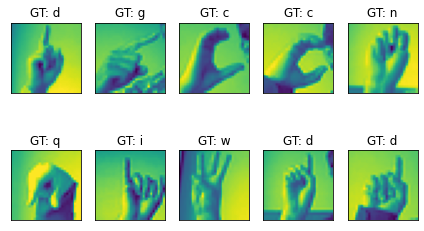

In [3]:
def show_img(x, gt, preds, rs, re, rows, cols):
    fig, ax = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True,)
    ax = ax.flatten()
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    for i in range(rs, re):
        ax[i%20].imshow(x[i])
        title = 'GT: ' + letters[int(np.where(gt[i]==1)[0])] 
        if preds is not None:
            title = title + ', L: ' + letters[int(preds[i])]
        ax[i].title.set_text(title)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
    
show_img(x_train, y_train, None, 0, 10, 2, 5)

## Create CNN

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
model = Sequential(name="CoolCodename")

model.add(Conv2D(filters=64,
                 kernel_size=3,
                 activation='relu',
                 padding='valid',
                 input_shape=x_train[0].shape))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,
                 kernel_size=3,
                 activation='relu',
                 padding='valid'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=32,
                 kernel_size=3,
                 activation='relu',
                 padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32,
                 kernel_size=3,
                 activation='relu',
                 padding='valid'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(y_train[0].shape[0], activation='softmax'))

model.summary()

Model: "CoolCodename"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)       

## Train Model

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_acc',
                        mode='max',
                        restore_best_weights=True,
                        patience=5)

epochs = 20

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[monitor])

Epoch 1/20
773/773 [==============================] - 53s 67ms/step - loss: 1.0066 - acc: 0.7356 - val_loss: 0.0100 - val_acc: 1.0000
Epoch 2/20
773/773 [==============================] - 50s 65ms/step - loss: 0.0483 - acc: 0.9909 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 3/20
773/773 [==============================] - 50s 65ms/step - loss: 0.0050 - acc: 0.9999 - val_loss: 3.6991e-04 - val_acc: 1.0000
Epoch 4/20
773/773 [==============================] - 50s 65ms/step - loss: 0.0213 - acc: 0.9943 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 5/20
773/773 [==============================] - 50s 65ms/step - loss: 0.0094 - acc: 0.9990 - val_loss: 6.1485e-04 - val_acc: 1.0000
Epoch 6/20
773/773 [==============================] - 50s 65ms/step - loss: 0.0378 - acc: 0.9901 - val_loss: 3.9262e-04 - val_acc: 1.0000


## Evaluate model


++++++++++++ Test data ++++++++++++
loss=0.2028 acc=0.9359


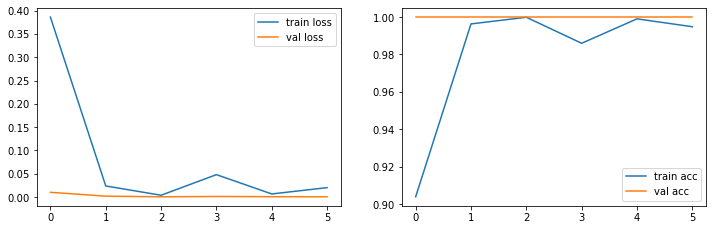

In [7]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()

loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\n++++++++++++ Test data ++++++++++++\nloss={loss:.4f} acc={acc:.4f}")

In [8]:
predictions = model.predict(x_test)
prediction_classes = np.argmax(predictions, axis=-1)

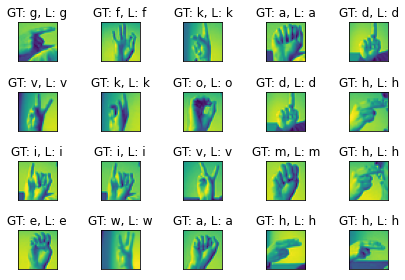

In [9]:
show_img(x_test, y_test, prediction_classes, 0, 20, 4, 5)

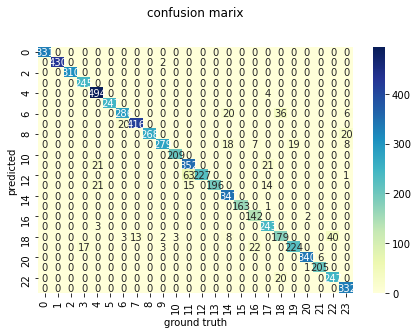

In [10]:
from sklearn import metrics

gt_classes = np.argmax(y_test, axis=-1)
confusion_matrix = metrics.confusion_matrix(gt_classes, prediction_classes)

sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu", fmt='d')
plt.tight_layout()
plt.title('confusion marix', y=1.1)
plt.ylabel('predicted')
plt.xlabel('ground truth')
plt.show()